## Análise dos dados do dataset

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown

pd.set_option("display.max_rows", 15)
pd.set_option('display.max_columns',100)

In [2]:
df = pd.read_csv('../dataset/B2W-Reviews01.csv')

display(df.info(),df.sample())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


c:\Users\STEFA\Anaconda3\envs\apolo\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


None

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
124462,2018-05-21 03:17:43,e2d01a56290f168afc92dd0f5b77b06d3659a6539dc0a8...,27724845,Kit 4 UN Focus Max 30 Caps,NaN,Suplementos e Vitaminas,Vitaminas & Minerais,Pessima,1,No,Gente comprei e nunca me entregaram so foi de...,1992.0,F,PI


In [3]:
df.dropna(subset=['review_title', 'overall_rating','recommend_to_a_friend','review_text','reviewer_birth_year'],inplace=True)
df['reviewer_birth_year'] = df['reviewer_birth_year'].astype('int')
df['recommend_to_a_friend_cat'] = df['recommend_to_a_friend'].map({'Yes':1,'No':0})

## Gráficos

#### Distribuição do sexo dos usuários com relação a quantidade de avaliações

##### Neste gráfico nós vemos a distribuição do sexo dos usuários com relação a quantidade de avaliações boas ou ruins de um determinado produto. 

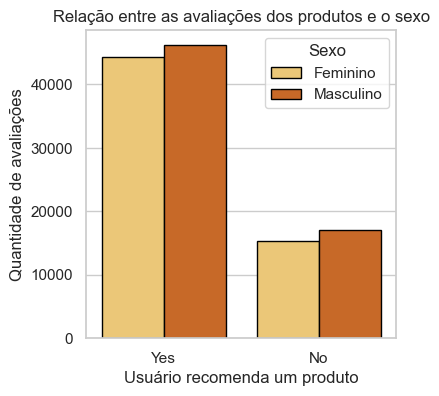

In [58]:
display(Markdown("##### Neste gráfico nós vemos a distribuição do sexo dos usuários com relação a quantidade de avaliações boas ou ruins de um determinado produto. "))
sns.set(style="whitegrid")
plt.figure(figsize=(4,4))
sns.countplot(x='recommend_to_a_friend', data = df, hue='reviewer_gender',palette='YlOrBr',edgecolor = "black")
plt.xlabel("Usuário recomenda um produto")
plt.ylabel("Quantidade de avaliações")
plt.title("Relação entre as avaliações dos produtos e o sexo")
plt.legend(title='Sexo', loc='upper right', labels=['Feminino', 'Masculino'])
plt.show()

#### Number of positive and negative reviews

In [56]:
data = df[df['recommend_to_a_friend']=='Yes']['product_name'].value_counts().to_frame().reset_index()
data.rename(columns={'index':'Product Name','product_name':'Number of positive reviews'},inplace=True)
display(data[0:15])

,Product Name,Number of positive reviews
0,Aspirador de Pó Philco Rapid 1000N Vermelho/Pr...,705
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,678
2,Smartphone Samsung Galaxy J7 Metal Dual Chip A...,593
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,470
4,Smartphone Samsung Galaxy J7 Prime Dual Chip A...,429
5,Smartphone Samsung Galaxy J5 Prime Dual Chip A...,422
6,"Smart TV LED 32"" Samsung 32J4300 HD com Conver...",402
7,Smartphone Moto G 5S Dual Chip Android 7.0 Tel...,369
8,Smartphone Samsung Galaxy J5 Pro Dual Chip And...,366
9,Smartphone Samsung Galaxy J7 Metal Dual Chip A...,361


In [57]:
data = df[df['recommend_to_a_friend']=='No']['product_name'].value_counts().to_frame().reset_index()
data.rename(columns={'index':'Product Name','product_name':'Number of negative reviews'},inplace=True)
display(data[0:15])

,Product Name,Number of negative reviews
0,Game God Of War - PS4,148
1,"Smart TV LED 39"" Philco PH39N86DSGW HD com Con...",110
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,74
3,"Smart TV LED 32"" Samsung 32J4300 HD com Conver...",71
4,Smartphone Samsung Galaxy J7 Prime Dual Chip A...,64
5,Chapinha Prancha Profissional Nano Titanium 1 ...,64
6,Smartphone Samsung Galaxy J5 Prime Dual Chip A...,62
7,Jogo de Panelas Euro Home Ágatha Colors 5 Peça...,55
8,Smartphone Motorola Moto G 5S Dual Chip Androi...,54
9,"Smart TV LED 55"" Philco PH55A17DSGWA4k Ultra H...",54


#### Faixa etária e avaliação

- 0-15: Grupo 1
- 15-25: Grupo 2
- 25-35: Grupo 3
- 35-50: Grupo 4
- 60-100: Grupo 5

In [68]:
def age_year(age):
    if(age<100):
        age = 1900 + age
    return 2023-age

df['age'] = df['reviewer_birth_year'].apply(age_year)

In [80]:
#Considera como outlier todos os usuarios com idade acima de 100 anos
data = df[df['age']<=100]